# Segmentation networks

In the notebook will be demontsrated how to use UNet, LinkNet, FCN32 and FCN8 (realized as TFModel) to segmenation images with MNIST digits.

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append("..")
from dataset import Pipeline, B, V
from dataset.opensets import MNIST
from dataset.models.tf import FCN32, FCN16, FCN8, LinkNet, UNet, VNet, RefineNet

from multiple_mnist import MultiMNIST, demonstrate_model, get_plots
from utils import interactive_plot

Load MNIST dataset. MultiMNIST is ImagesBatch class with action that creates images with MNIST digits in random locations.

In [2]:
mnist = MNIST(batch_class=MultiMNIST)

Extracting ExtractingExtractingExtractingC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz   
C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gz




Define some constants and auxilary function

In [3]:
BATCH_SIZE = 64
MAX_ITER = 1000
SHAPE = (100, 100)

Create model config

In [4]:
model_config = {'loss': 'softmax_cross_entropy',
                'input_block/inputs': 'images',
                'optimizer': {'name':'Adam', 
                              'use_locking': True},
                # inputs is a config dict to create placeholders
                'inputs':    {'images': {'shape': (None, None, 1)},  # shape of the input images
                              'masks':  {'shape': (None, None),      # shape of masks
                                         'classes': 11,              # number of segmantation classes
                                         'transform': ['dwn', 'ohe'],         # apply one-hot encoding to masks
                                         'name': 'targets',
                                        'factor': 4}
                                         },        # name of the tf.Tensor after transformation
                'filters': 64,                                       # number of filters before the first downsampling block
                'num_blocks': 3,
                'output': {'ops': ['proba', 'labels']}}              # compute probability from logit output

In [5]:
train_template = (Pipeline()
                  .normalize_images()
                  .resize(shape=(100,100))
                  .make_masks()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('current_loss', init_on_each_run=0)
                  .init_model('dynamic', RefineNet, 'conv', config=model_config)
                  .train_model('conv', fetches='loss', feed_dict={'images': B('images'),
                                                                  'masks': B('masks')}, 
                               save_to=V('current_loss'))
                  .update_variable('loss_history', V('current_loss'), mode='a'))

train_pp = (train_template << mnist.train)

In [33]:
batch = (mnist.train.p
                  .normalize_images()
                  .resize(shape=(100,100))
                  .make_masks().next_batch(10))

Train UNet on MNIST images

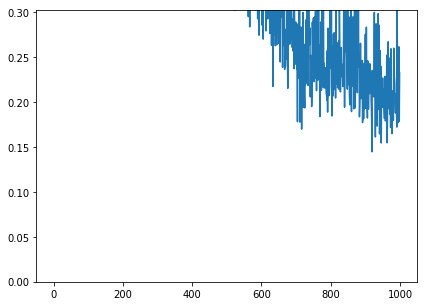

Training time: 13.59 min


In [6]:
print("Start training...")
t = time()
for i in range(MAX_ITER):
    train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=True, prefetch=0)
    interactive_plot([train_pp.get_variable('loss_history')])
    
print("Training time: {:4.2f} min".format((time() - t)/60))

Create test pipeline for segmentation images with multiple MNIST digits in random locations.

In [29]:
test_template = (Pipeline()
                 .normalize_images()
                 .make_masks()
                 .import_model('conv', train_pp)
                 .init_variable('predicted_proba', init_on_each_run=list)
                 .init_variable('predicted_labels', init_on_each_run=list)
                 .predict_model('conv', fetches=['RefineNet/output/proba', 'RefineNet/output/labels'],
                               feed_dict={'images': B('images'),
                                          'masks': B('masks')},
                               save_to=[V('predicted_proba'), V('predicted_labels')], mode='a'))

test_ppl = (test_template << mnist.test)

In [17]:
res = test_ppl.get_model_by_name('conv')
ses = res.session
gr = ses.graph

In [28]:
for i in gr.get_operations():
    print(i.name)

RefineNet/globals/is_training
RefineNet/globals/global_step/initial_value
RefineNet/globals/global_step
RefineNet/globals/global_step/Assign
RefineNet/globals/global_step/read
RefineNet/inputs/images
RefineNet/inputs/masks
RefineNet/inputs/Shape
RefineNet/inputs/strided_slice/stack
RefineNet/inputs/strided_slice/stack_1
RefineNet/inputs/strided_slice/stack_2
RefineNet/inputs/strided_slice
RefineNet/inputs/truediv/y
RefineNet/inputs/truediv/Cast
RefineNet/inputs/truediv/Cast_1
RefineNet/inputs/truediv
RefineNet/inputs/Cast
RefineNet/inputs/ExpandDims/dim
RefineNet/inputs/ExpandDims
RefineNet/inputs/ResizeNearestNeighbor
RefineNet/inputs/Squeeze
RefineNet/inputs/one_hot/on_value
RefineNet/inputs/one_hot/off_value
RefineNet/inputs/one_hot/depth
RefineNet/inputs/one_hot
RefineNet/inputs/targets
RefineNet/input_block/layer-0/conv2d/kernel/Initializer/random_uniform/shape
RefineNet/input_block/layer-0/conv2d/kernel/Initializer/random_uniform/min
RefineNet/input_block/layer-0/conv2d/kernel/In

RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Initializer/random_uniform/min
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Initializer/random_uniform/max
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Initializer/random_uniform/RandomUniform
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Initializer/random_uniform/sub
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Initializer/random_uniform/mul
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Initializer/random_uniform
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/Assign
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/kernel/read
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/bias/Initializer/zeros
RefineNet/body/encoder/body/group-1/block-3/sub/layer-7/conv2d/bias
RefineNet/bo

RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg/read
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg/Sub
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg/Mul
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg_1/read
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg_1/Sub
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg_1/Mul
RefineNet/body/encoder/body/group-2/block-9/sub/layer-8/batch_normalization/AssignMovingAvg_1
RefineNet/body/encoder/body/group-2/block-9/add
RefineNet/body/encoder/body/group-2/block-9/output
RefineNet/body/encoder/body/group-2/output_9
RefineNet/body/encoder/body/group-2/block-10/sub/Relu
RefineNet/body/encoder/body/grou

RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/kernel
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/kernel/Assign
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/kernel/read
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/bias/Initializer/zeros
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/bias
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/bias/Assign
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/bias/read
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/dilation_rate
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/Conv2D
RefineNet/body/encoder/body/group-2/block-21/sub/layer-4/conv2d/BiasAdd
RefineNet/body/encoder/body/group-2/block-21/sub/layer-5/batch_normalization/gamma/Initializer/ones
RefineNet/body/encoder/body/group-2/block-21/sub/layer-5/batch_normalization/gamma
RefineNet/body/encoder/body/group-2/block-21/sub/layer-5/batch_no

RefineNet/head/layer-0/conv2d_transpose/strided_slice_1/stack
RefineNet/head/layer-0/conv2d_transpose/strided_slice_1/stack_1
RefineNet/head/layer-0/conv2d_transpose/strided_slice_1/stack_2
RefineNet/head/layer-0/conv2d_transpose/strided_slice_1
RefineNet/head/layer-0/conv2d_transpose/strided_slice_2/stack
RefineNet/head/layer-0/conv2d_transpose/strided_slice_2/stack_1
RefineNet/head/layer-0/conv2d_transpose/strided_slice_2/stack_2
RefineNet/head/layer-0/conv2d_transpose/strided_slice_2
RefineNet/head/layer-0/conv2d_transpose/mul/y
RefineNet/head/layer-0/conv2d_transpose/mul
RefineNet/head/layer-0/conv2d_transpose/mul_1/y
RefineNet/head/layer-0/conv2d_transpose/mul_1
RefineNet/head/layer-0/conv2d_transpose/stack/3
RefineNet/head/layer-0/conv2d_transpose/stack
RefineNet/head/layer-0/conv2d_transpose/conv2d_transpose_2
RefineNet/head/layer-0/conv2d_transpose/BiasAdd
RefineNet/head/Shape
RefineNet/head/strided_slice/stack
RefineNet/head/strided_slice/stack_1
RefineNet/head/strided_slice/s

RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-19/sub/layer-5/batch_normalization/cond/FusedBatchNorm_1_grad/tuple/control_dependency
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-19/sub/layer-5/batch_normalization/cond/FusedBatchNorm_1_grad/tuple/control_dependency_1
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-19/sub/layer-5/batch_normalization/cond/FusedBatchNorm_1_grad/tuple/control_dependency_2
RefineNet/gradients/zeros_like_109
RefineNet/gradients/zeros_like_110
RefineNet/gradients/zeros_like_111
RefineNet/gradients/zeros_like_112
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-19/sub/layer-5/batch_normalization/cond/FusedBatchNorm_grad/FusedBatchNormGrad
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-19/sub/layer-5/batch_normalization/cond/FusedBatchNorm_grad/tuple/group_deps
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-19/sub/layer-5/batch_normalization/cond/FusedBatchNorm_grad/tuple/c

RefineNet/gradients/AddN_198
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/layer-1/conv2d/Conv2D_grad/ShapeN
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/layer-1/conv2d/Conv2D_grad/Conv2DBackpropInput
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/layer-1/conv2d/Conv2D_grad/Conv2DBackpropFilter
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/layer-1/conv2d/Conv2D_grad/tuple/group_deps
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/layer-1/conv2d/Conv2D_grad/tuple/control_dependency
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/layer-1/conv2d/Conv2D_grad/tuple/control_dependency_1
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-8/sub/Relu_grad/ReluGrad
RefineNet/gradients/AddN_199
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-7/add_grad/Shape
RefineNet/gradients/RefineNet/body/encoder/body/group-2/block-7/add_grad/Shape_1
RefineNe

RefineNet/gradients/zeros_499
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-8/batch_normalization/cond/FusedBatchNorm/Switch_2_grad/cond_grad
RefineNet/gradients/AddN_310
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-7/conv2d/BiasAdd_grad/BiasAddGrad
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-7/conv2d/BiasAdd_grad/tuple/group_deps
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-7/conv2d/BiasAdd_grad/tuple/control_dependency
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-7/conv2d/BiasAdd_grad/tuple/control_dependency_1
RefineNet/gradients/AddN_311
RefineNet/gradients/AddN_312
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-7/conv2d/Conv2D_grad/ShapeN
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block-0/sub/layer-7/conv2d/Conv2D_grad/Conv2DBackpropInput
RefineNet/gradients/RefineNet/body/encoder/body/group-1/block

RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-4/conv2d/bias/Adam_1/Initializer/zeros
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-4/conv2d/bias/Adam_1
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-4/conv2d/bias/Adam_1/Assign
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-4/conv2d/bias/Adam_1/read
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-5/batch_normalization/gamma/Adam/Initializer/zeros
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-5/batch_normalization/gamma/Adam
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-5/batch_normalization/gamma/Adam/Assign
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-5/batch_normalization/gamma/Adam/read
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-5/batch_normalization/gamma/Adam_1/Initializer/zeros
RefineNet/RefineNet/body/encoder/body/group-2/block-7/sub/layer-5/batch_normalization/gamma/Ada

RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam/Initializer/zeros
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam/Assign
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam/read
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam_1/Initializer/zeros
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam_1
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam_1/Assign
RefineNet/RefineNet/body/decoder-3/rcu-0/block-2/sub/layer-3/conv2d/bias/Adam_1/read
RefineNet/RefineNet/body/decoder-3/rcu-1/block-1/sub/layer-1/conv2d/kernel/Adam/Initializer/zeros
RefineNet/RefineNet/body/decoder-3/rcu-1/block-1/sub/layer-1/conv2d/kernel/Adam
RefineNet/RefineNet/body/decoder-3/rcu-1/block-1/sub/layer-1/conv2d/kernel/Adam/Assign
RefineNet/RefineNet/body/decoder-3/rcu-1/bl

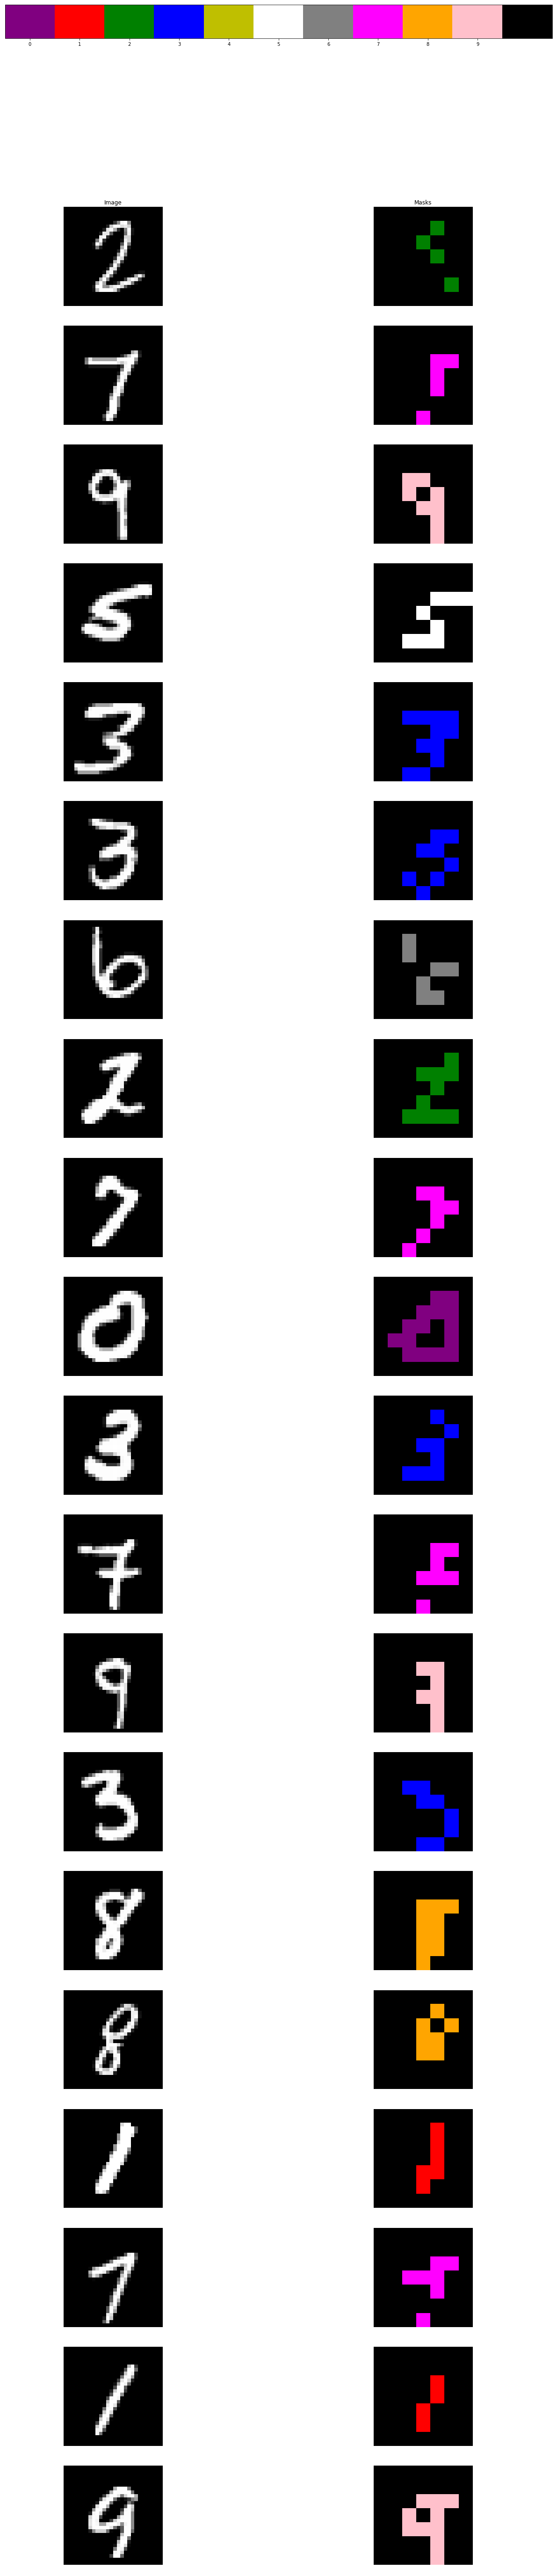

In [30]:
get_plots(test_ppl, mode='c', inverse=True, n_examples=20, batch_size=64)

Now let's demonstrate result for other segmentation networks.

In [ ]:
demonstrate_model(RefineNet, max_iter=MAX_ITER)

In [ ]:
demonstrate_model(VNet, max_iter=MAX_ITER)

In [ ]:
demonstrate_model(FCN32, max_iter=MAX_ITER)

In [ ]:
demonstrate_model(FCN16, max_iter=MAX_ITER)

In [ ]:
demonstrate_model(FCN8, max_iter=MAX_ITER)

In [ ]:
demonstrate_model(LinkNet, filters=128, max_iter=MAX_ITER)